In [26]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ---------------------------
# 0️⃣ Device
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ---------------------------
# 1️⃣ Load & preprocess data
# ---------------------------
data = pd.read_csv("F:\VidyutAI\data\hourlyEVusage_cleaned.csv")  # Replace with your CSV

# Parse datetime
data['Datetime'] = pd.to_datetime(data['Datetime'], dayfirst=True, errors='coerce')
data = data.dropna(subset=['Datetime']).sort_values('Datetime').reset_index(drop=True)
data.set_index('Datetime', inplace=True)

# Extract day of year and hour for cyclic encoding
day_of_year = data.index.dayofyear.values  # 1-366
hour_of_day = data.index.hour.values       # 0-23

# Cyclic encoding
data['day_sin'] = np.sin(2 * np.pi * day_of_year / 366)
data['day_cos'] = np.cos(2 * np.pi * day_of_year / 366)
data['hour_sin'] = np.sin(2 * np.pi * hour_of_day / 24)
data['hour_cos'] = np.cos(2 * np.pi * hour_of_day / 24)

# Load column
data.rename(columns={'Energy_kWh':'Load'}, inplace=True)
load_values = data['Load'].values

# ---------------------------
# 2️⃣ Prepare sequences with cyclic features
# ---------------------------
history_hours = 24
forecast_hours = 24

X_seq, X_static, y = [], [], []

for i in range(history_hours, len(data)-forecast_hours):
    hist_load = load_values[i-history_hours:i]      # previous 24 hours
    future_load = load_values[i:i+forecast_hours]  # next 24 hours
    if np.any(np.isnan(hist_load)) or np.any(np.isnan(future_load)):
        continue

    # Sequence of load
    X_seq.append(hist_load.reshape(-1,1))
    
    # Static features: cyclic day/hour at prediction start
    X_static.append(data.iloc[i][['day_sin','day_cos','hour_sin','hour_cos']].values)
    
    y.append(future_load)

X_seq = np.array(X_seq)
X_static = np.array(X_static)
y = np.array(y)

# ---------------------------
# 3️⃣ Normalize load sequence & output
# ---------------------------
from sklearn.preprocessing import MinMaxScaler

scaler_seq = MinMaxScaler()
X_seq_scaled = scaler_seq.fit_transform(X_seq.reshape(-1,1)).reshape(X_seq.shape)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1,1)).reshape(y.shape)

# Static features (already cyclic - mostly -1..1, no need to scale)
# But optionally scale to [0,1]
scaler_static = MinMaxScaler()
X_static_scaled = scaler_static.fit_transform(X_static)

# ---------------------------
# 4️⃣ PyTorch Dataset
# ---------------------------
class LoadDataset(Dataset):
    def __init__(self, X_seq, X_static, y):
        self.X_seq = torch.tensor(X_seq, dtype=torch.float32)
        self.X_static = torch.tensor(X_static, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X_seq)

    def __getitem__(self, idx):
        return self.X_seq[idx], self.X_static[idx], self.y[idx]

# ---------------------------
# 5️⃣ Model: Complex stacked BiLSTM
# ---------------------------
class ComplexLSTM24to24(nn.Module):
    def __init__(self, history_len=24, static_dim=4, lstm_hidden=128, lstm_layers=2, forecast_len=24, dropout=0.2):
        super().__init__()
        self.history_len = history_len
        self.forecast_len = forecast_len

        # BiLSTM for sequence
        self.lstm_seq = nn.LSTM(input_size=1, hidden_size=lstm_hidden,
                                num_layers=lstm_layers, batch_first=True,
                                dropout=dropout, bidirectional=True)

        # Static features
        self.fc_static = nn.Linear(static_dim, 32)

        # Combine features
        self.fc_comb = nn.Linear(lstm_hidden*2 + 32, 128)
        self.dropout = nn.Dropout(dropout)

        # Forecast LSTM
        self.lstm_forecast = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.out = nn.Linear(64, 1)

    def forward(self, x_seq, x_static):
        h_seq, _ = self.lstm_seq(x_seq)
        h_seq_last = h_seq[:, -1, :]
        h_static = torch.relu(self.fc_static(x_static))
        h = torch.cat([h_seq_last, h_static], dim=1)
        h = torch.relu(self.fc_comb(h))
        h = self.dropout(h)
        h = h.unsqueeze(1).repeat(1, self.forecast_len, 1)
        h2, _ = self.lstm_forecast(h)
        out = self.out(h2).squeeze(-1)
        return out

# ---------------------------
# 6️⃣ Train function
# ---------------------------
def train_model(model, train_loader, val_loader, epochs=1000, lr=5e-5):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0
        for x_seq, x_static, y_batch in train_loader:
            x_seq, x_static, y_batch = x_seq.to(device), x_static.to(device), y_batch.to(device)
            optimizer.zero_grad()
            out = model(x_seq, x_static)
            loss = criterion(out, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x_seq.size(0)
        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_seq, x_static, y_batch in val_loader:
                x_seq, x_static, y_batch = x_seq.to(device), x_static.to(device), y_batch.to(device)
                out = model(x_seq, x_static)
                val_loss += criterion(out, y_batch).item() * x_seq.size(0)
        val_loss /= len(val_loader.dataset)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}  Train Loss: {train_loss:.6f}  Val Loss: {val_loss:.6f}")

# ---------------------------
# 7️⃣ Plot function
# ---------------------------
def plot_instance(model, X_seq, X_static, y, instance, scaler_y, scaler_static):
    model.eval()
    x_seq = torch.tensor(X_seq[instance:instance+1], dtype=torch.float32).to(device)
    x_static = torch.tensor(X_static[instance:instance+1], dtype=torch.float32).to(device)
    with torch.no_grad():
        pred_scaled = model(x_seq, x_static).cpu().numpy()[0]
    actual_scaled = y[instance]

    pred = scaler_y.inverse_transform(pred_scaled.reshape(-1,1))[:,0]
    actual = scaler_y.inverse_transform(actual_scaled.reshape(-1,1))[:,0]

    static_info = scaler_static.inverse_transform(X_static[instance].reshape(1,-1))[0]
    hours = [(int(round((np.arctan2(static_info[2],static_info[3])*12/np.pi+24)%24))+i) % 24 for i in range(24)]

    plt.figure(figsize=(10,4))
    plt.plot(pred, 'o--', label='Predicted', color='red')
    plt.plot(actual, 'o-', label='Actual', color='blue')
    plt.xticks(range(24), [f"{h:02d}:00" for h in hours], rotation=45)
    plt.xlabel("Hour of Day")
    plt.ylabel("Load (kWh)")
    plt.title(f"Next 24h forecast from day/hour cyclic features")
    plt.legend()
    plt.show()


<>:18: SyntaxWarning: invalid escape sequence '\V'
<>:18: SyntaxWarning: invalid escape sequence '\V'
C:\Users\Magnet\AppData\Local\Temp\ipykernel_21988\1909809612.py:18: SyntaxWarning: invalid escape sequence '\V'
  data = pd.read_csv("F:\VidyutAI\data\hourlyEVusage_cleaned.csv")  # Replace with your CSV


Using device: cuda


Epoch 10/300  Train Loss: 0.012034  Val Loss: 0.015886
Epoch 20/300  Train Loss: 0.009244  Val Loss: 0.009404
Epoch 30/300  Train Loss: 0.006782  Val Loss: 0.006876
Epoch 40/300  Train Loss: 0.006640  Val Loss: 0.006379
Epoch 50/300  Train Loss: 0.006572  Val Loss: 0.006517
Epoch 60/300  Train Loss: 0.006488  Val Loss: 0.006607
Epoch 70/300  Train Loss: 0.006442  Val Loss: 0.006134
Epoch 80/300  Train Loss: 0.006410  Val Loss: 0.006749
Epoch 90/300  Train Loss: 0.006325  Val Loss: 0.006495
Epoch 100/300  Train Loss: 0.006285  Val Loss: 0.006958
Epoch 110/300  Train Loss: 0.006245  Val Loss: 0.007151
Epoch 120/300  Train Loss: 0.006183  Val Loss: 0.006968
Epoch 130/300  Train Loss: 0.006138  Val Loss: 0.007048
Epoch 140/300  Train Loss: 0.006079  Val Loss: 0.007002
Epoch 150/300  Train Loss: 0.006041  Val Loss: 0.007286
Epoch 160/300  Train Loss: 0.005996  Val Loss: 0.007216
Epoch 170/300  Train Loss: 0.005930  Val Loss: 0.007186
Epoch 180/300  Train Loss: 0.005956  Val Loss: 0.007239
E

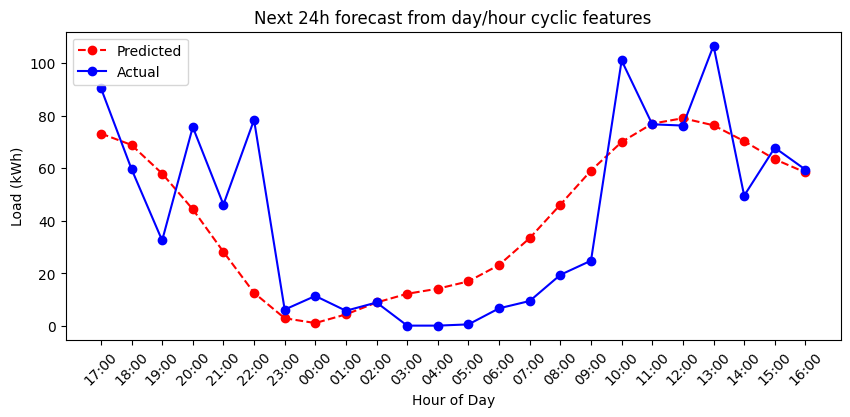

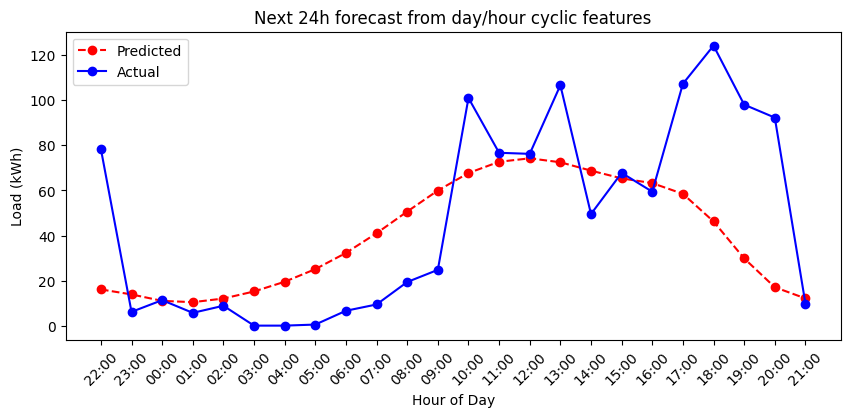

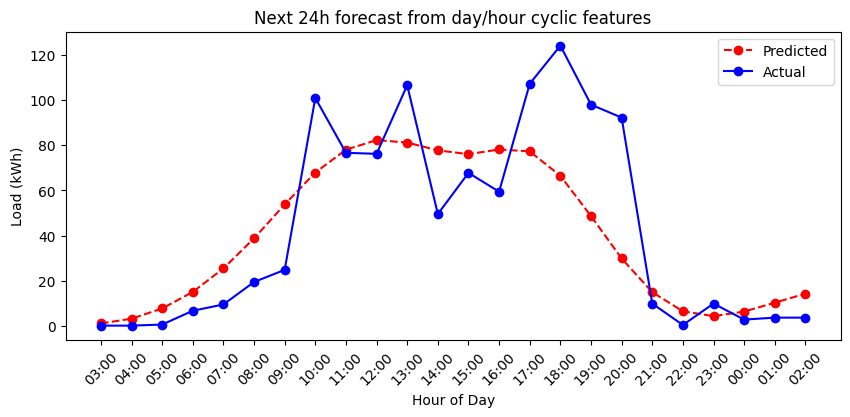

In [30]:
split_idx = int(len(X_seq_scaled)*0.9)
train_dataset = LoadDataset(X_seq_scaled[:split_idx], X_static_scaled[:split_idx], y_scaled[:split_idx])
val_dataset = LoadDataset(X_seq_scaled[split_idx:], X_static_scaled[split_idx:], y_scaled[split_idx:])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

model = ComplexLSTM24to24()
train_model(model, train_loader, val_loader, epochs=300, lr=1e-4)

# Plot some instances
for inst in [0, 5, 10]:
    plot_instance(model, X_seq_scaled[split_idx:], X_static_scaled[split_idx:], y_scaled[split_idx:], inst, scaler_y, scaler_static)

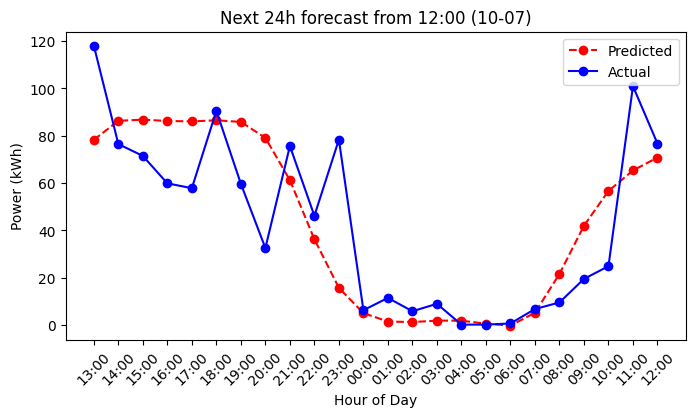

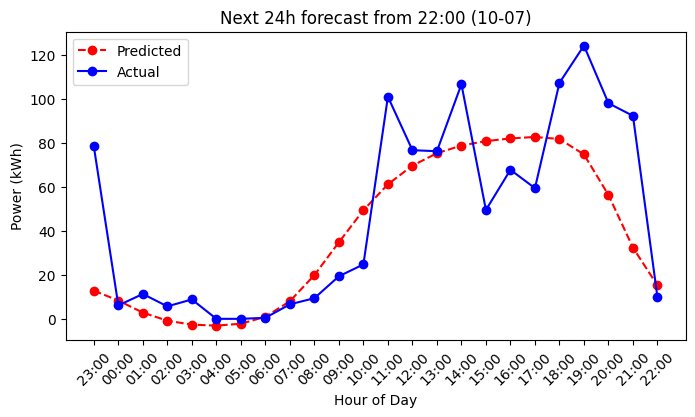

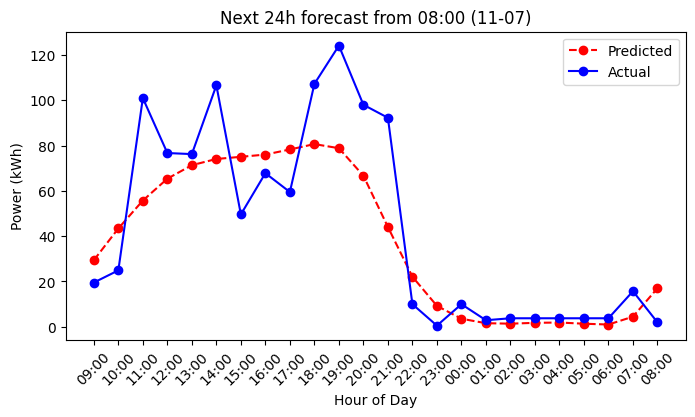

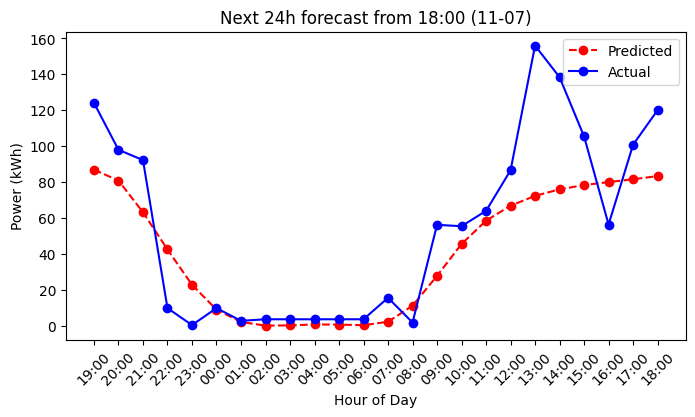

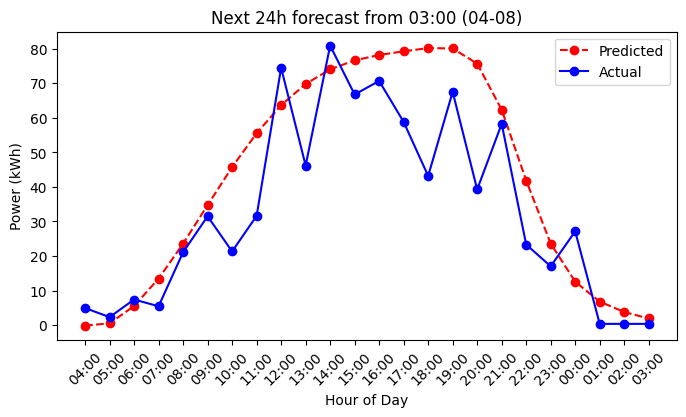

In [11]:
# Plot a few instances
for inst in range(1, 50, 10):
    plot_instance(model, X_seq[split_idx:], X_static[split_idx:], y[split_idx:], inst, scaler_power, scaler_static)
